# Training with Data Augmentation (Batches)

In [28]:
import msprime
from IPython.display import SVG, display
import networkx as nx
import jax
import jax.numpy as nmp
from jax.nn import log_softmax
import equinox as eqx
import itertools as it
import optax
import tskit
import numpy as np
from collections import defaultdict
import bisect

In [14]:
num_ts = 100

In [ ]:
ts = msprime.sim_ancestry(
        samples=4,
        recombination_rate=1e-8,
        sequence_length=20_000,
        population_size=8_000)
mts = msprime.sim_mutations(ts, rate = 1e-8)
sparse_genotype = mts.genotype_matrix().T
breakpoints = list(mts.breakpoints())
mutation_sites = [site.position for site in mts.sites()]

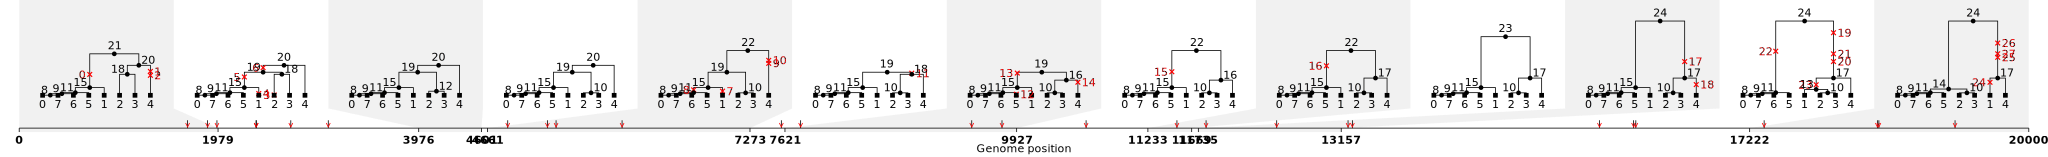

In [17]:
SVG(mts.draw_svg())

In [18]:
dods = [tree.as_dict_of_dicts() for tree in ts.trees()]
tree_graphs = [nx.Graph(dod) for dod in dods]
edge_pairs = [list(tree_graph.edges) for tree_graph in tree_graphs]
edge_pairs_backwards = [[(b, a) for (a, b) in sublist] for sublist in edge_pairs]
senders = [np.array([a for (a, b) in sublist]) for sublist in edge_pairs_backwards]
receivers = [np.array([b for (a, b) in sublist]) for sublist in edge_pairs_backwards]


In [19]:
def diff_spr(t1, t2):
    assert t1.num_samples() == t2.num_samples()
    nodes = set(range(t1.num_samples()))
    while nodes:
        x = nodes.pop()
        p1, p2 = [t.get_parent(x) for t in [t1, t2]]
        if p1 != p2:
            return x
        if p1 != -1:
            nodes.add(p1)
            
def find_spr(t1, t2):
    start0 = diff_spr(t1, t2)
    deleted = t1.parent(start0)
    start1, = t1.siblings(start0)
    # the recombination could have occured either on (start0, deleted) or (start1, deleted)
    # to settle this, in t2, one of them will have the same grandparent and the other wont
    gp = t1.parent(deleted)
    gp0 = t2.parent(start0)
    gp1 = t2.parent(start1)
    start = start1 if gp0 == gp else start0
    end, = t2.siblings(start)
    if t1.parent(end) == tskit.NULL:
        x = t2.time(t2.parent(end)) - t2.time(end)
        root = True
    else:
        t0 = t1.time(t1.parent(end)) - t1.time(end)
        t1 = t2.time(t2.parent(end)) - t2.time(end)
        x = t1 / t0
        root = False
    return (start, deleted)

In [20]:
true_edges = [find_spr(t1, t2) for t1, t2 in it.pairwise(ts.aslist())]
true_edge_indices = [sublist.index(edge) for edge, sublist in zip(true_edges, edge_pairs_backwards)]

In [10]:
# take a matrix of just the kept columns and expand with zeroes everywhere else for a fixed range of the full matrix.
def restore_and_slice(X, start, end, kept_cols):
  n = X.shape[0]
  n_cols = int(end - start)

  full_sub = np.zeros((n, n_cols))

  for idx, col in enumerate(kept_cols):
    if start <= col < end:
      full_sub[:, int(col-start)] = X[:, idx]

  return full_sub

# do this for the genotype matrix
def make_genotype_windows(G, tree_num, breakpoints, mutation_sites):
  start_site = breakpoints[tree_num+1]
  end_site = breakpoints[tree_num + 2]

  start_genotype = start_site
  if end_site < (start_site + 100):
    end_genotype = end_site
  else:
    end_genotype = start_site + 100
  
  G_sub = restore_and_slice(X=G, start = start_genotype, end = end_genotype, kept_cols=mutation_sites)
  
  return G_sub

In [71]:
genotypes = [
    make_genotype_windows(
        G=sparse_genotype,
        tree_num=i,
        breakpoints=breakpoints,
        mutation_sites=mutation_sites
    )
    for i in range(len(breakpoints) - 2)  # number of trees
]
genotypes_compressed = [G.sum(axis = 1) for G in genotypes]

In [72]:
genotypes_compressed

[array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 1., 0., 0., 0.]),
 array([0., 1., 1., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.])]

In [67]:
seg_sites_before_after = []
for point in breakpoints[1:-1]:
  idx = bisect.bisect_left(mutation_sites, point)
  start = max(0, idx - 3)
  end = min(len(mutation_sites), idx + 3)
  seg_sites_before_after.append(mutation_sites[start:end])
sparse_matrix_indicators = [[mutation_sites.index(site) for site in sites] for sites in seg_sites_before_after]
segregating_sites = [sparse_genotype[:, indicators] for indicators in sparse_matrix_indicators]

In [ ]:
init_feats = [np.column_stack((M, v)) for M, v in zip(segregating_sites, genotypes_compressed)]

[array([[1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 1., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0.]]),
 array([[0., 1., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0.]]),
 array([[0., 1., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
      

In [76]:
class InitMLP:
  def __init__(self, input_dim, hidden_dim, num_hidden, output_dim, key):
    self.params = []
    keys = jax.random.split(key, num_hidden + 1)

    last_dim = input_dim
    for i, k in enumerate(keys[: -1]):
      W = jax.random.normal(k, (last_dim, hidden_dim)) / nmp.sqrt(last_dim)
      b = jax.random.normal(k, hidden_dim) / nmp.sqrt(num_hidden)
      self.params.append((W, b))
      last_dim = hidden_dim
    
    W = jax.random.normal(keys[-1], (output_dim, last_dim)) / nmp.sqrt(output_dim)
    b = jax.random.normal(keys[-1], output_dim)
    self.params.append((W, b))
  
  def __call__(self, X):
    h = X
    for (W, b) in self.params[:-1]:
      h = jax.nn.relu(h @ W + b)
    W, b = self.params[-1]
    return h @ W + b

key = jax.random.PRNGKey(1997)
init_embedder = InitMLP(input_dim=7, hidden_dim=64, num_hidden=2, output_dim=64, key=key)

In [78]:
init_embeds = []
for G in init_feats:
  x = nmp.array(G, dtype=nmp.float32)
  z = init_embedder(x)
  init_embeds.append(z)

In [80]:
init_embeds[0]

Array([[ 2.28547192e+00,  4.10339311e-02, -1.56359196e+00,
        -1.76844150e-01, -2.50522161e+00, -2.74471307e+00,
        -4.37602848e-01, -2.69830823e+00,  4.77412075e-01,
         1.39977419e+00,  1.11635554e+00, -3.25809658e-01,
         2.89290023e+00, -6.22110367e-01,  2.12518454e+00,
        -1.80725956e+00,  1.18503153e+00, -1.50183153e+00,
        -1.61827219e+00,  2.56336808e+00,  2.40394592e+00,
         8.18233073e-01, -2.53893566e+00,  3.42894197e-02,
         1.99315143e+00,  7.79463053e-01, -4.96230483e-01,
         2.19166279e-04, -1.45927978e+00, -1.25189781e+00,
        -1.71165729e+00,  8.21976602e-01,  5.43391049e-01,
        -4.19693470e-01,  2.33825397e+00,  2.81271267e+00,
        -9.36242104e-01, -1.10627365e+00,  7.67453015e-02,
         3.53338122e-01, -8.38512301e-01,  2.41724953e-01,
        -2.14571142e+00, -1.25533795e+00,  1.15111566e+00,
        -3.56228799e-01,  1.21098602e+00, -7.47772396e-01,
        -2.38897607e-01,  5.71602702e-01, -6.57240152e-0

In [62]:
N = max([max(tree_graph.nodes) for tree_graph in tree_graphs]) + 1

In [ ]:
embeddings = [nmp.zeros((N, 64)) for i in range(len(breakpoints) - 2)]
for i in range(init_embeds.shape[0]):
  embeddings = embeddings.at[i].set(init_embeds[i])
embeddings